In [54]:
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

To examine the files I have read in the dataset from 2023

In [55]:
pd.read_csv('names/yob2023.txt',names = ['name', 'sex','numbers'], engine = 'pyarrow', dtype_backend = 'pyarrow').assign(year=2023)

,name,sex,numbers,year
0,Olivia,F,15270,2023
1,Emma,F,13527,2023
2,Charlotte,F,12596,2023
3,Amelia,F,12311,2023
4,Sophia,F,11944,2023
...,...,...,...,...
31677,Zyell,M,5,2023
31678,Zyen,M,5,2023
31679,Zymirr,M,5,2023
31680,Zyquan,M,5,2023


To continue we need the datas from all of the years. To achieve that we need to concatane the tables from each year.

In [56]:
allyears = pd.concat(pd.read_csv(f'names/yob{year}.txt', names=['name', 'sex', 'number'],
                                 engine='pyarrow', dtype_backend='pyarrow').assign(year=year)
                     for year in range(1880, 2024)) #we use a generator function here to concatenate the tables


In [57]:
allyears.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2117219 entries, 0 to 31681
Data columns (total 4 columns):
 #   Column  Dtype          
---  ------  -----          
 0   name    string[pyarrow]
 1   sex     string[pyarrow]
 2   number  int64[pyarrow] 
 3   year    int64          
dtypes: int64(1), int64[pyarrow](1), string[pyarrow](2)
memory usage: 79.1 MB


In [58]:
allyears = allyears.convert_dtypes(dtype_backend='pyarrow') #convert the year series to a 'pyarrow' dtype


After creating the unified table, we can start to analyze it.

In [59]:
allyears_indexed = allyears.set_index(['sex', 'name', 'year']).sort_index()

In [60]:
allyears_indexed

number
sex name   year        
F   Aabha  2011       7
           2012       5
           2014       9
           2015       7
           2016       7
...                 ...
M   Zyvion 2009       5
    Zyvon  2015       7
    Zyyon  2014       6
    Zzyzx  2010       5
           2018       5

[2117219 rows x 1 columns]

Getting the dataset for a given name could be easily done by using .loc()

In [61]:
allyears_indexed.loc[('F','Mary')]

,number
year,
1880,7065
1881,6919
1882,8148
1883,8012
1884,9217
...,...
2019,2237
2020,2225
2021,2097


Thus we can plot the popularity of the name over the years.

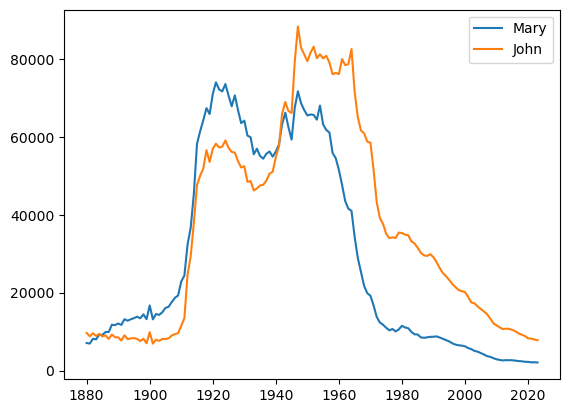

In [62]:
plt.plot(allyears_indexed.loc[('F','Mary'), 'number'], label='Mary')
plt.plot(allyears_indexed.loc[('M','John'), 'number'], label='John')
plt.legend();

In [63]:
births = allyears.groupby(['sex','year']).number.sum()

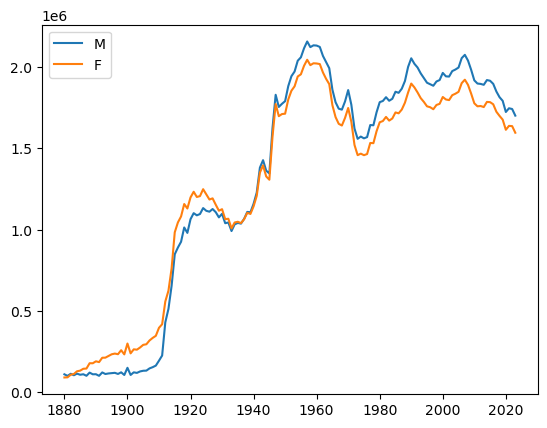

In [64]:
plt.plot(births.loc['M'], label='M')
plt.plot(births.loc['F'], label='F')
plt.legend();

Another interesting thing to investigate is the variance of a name.

In [65]:
def plotname(sex, name, relative=False):
    data = allyears_indexed.loc[(sex, name), 'fraction' if relative else 'number']
    
    plt.plot(data.index, data.values, label=name)
    plt.axis(xmin=1880, xmax=2023)

In [66]:
def comparenames(sex, names, relative=False):
    for name in names:
        plotname(sex, name, relative)

    plt.legend()

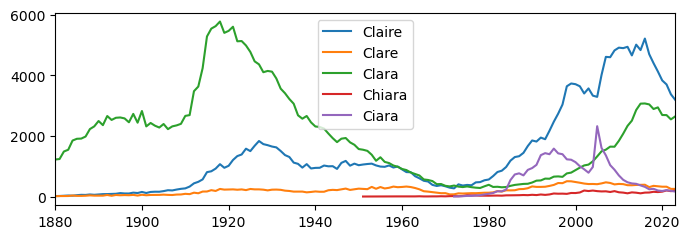

In [67]:
claires = ['Claire', 'Clare', 'Clara', 'Chiara', 'Ciara']
plt.figure(figsize=(8,2.5))
comparenames('F', claires)

In [68]:
unstacked = allyears_indexed.loc[('F', claires), 'number'] \
                            .unstack(level=2) \
                            .droplevel(level=0) \
                            .fillna(0)

In [69]:
unstacked

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
name,,,,,,,,,,,,,,,,,,,,,
Claire,21,23,30,38,33,49,61,58,73,62,...,5015,4836,5216,4701,4404,4130,3835,3702,3379,3195
Clare,15,20,21,22,38,27,26,31,43,34,...,387,389,394,315,357,344,329,329,257,257
Clara,1226,1242,1490,1548,1852,1910,1916,1984,2230,2319,...,2860,3069,3075,3044,2892,2946,2694,2691,2550,2648
Chiara,0,0,0,0,0,0,0,0,0,0,...,131,111,134,137,161,152,166,206,182,200
Ciara,0,0,0,0,0,0,0,0,0,0,...,424,372,324,244,259,204,188,215,192,169


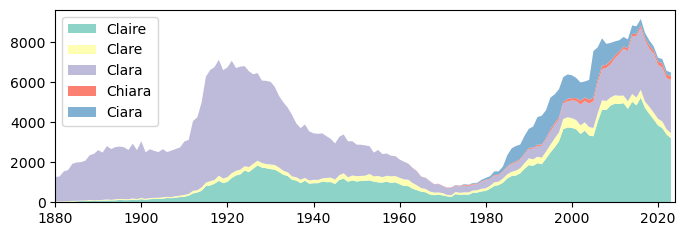

In [70]:
plt.figure(figsize=(8,2.5))
plt.stackplot(unstacked.columns, unstacked.astype(np.int32),
             colors=plt.get_cmap('Set3')(range(5))) # get the first five colors from the "Set3" matplotlib colormap  
plt.legend(unstacked.index, loc='upper left');
plt.axis(xmin=1880, xmax=2024);

Now we are going to create a yearly top 10 list of the most popular name


In [73]:
allyears = pd.read_feather('allyears.feather')

In [74]:
allyears_byyear = allyears.set_index(['sex','year']).sort_index()

In [75]:
allyears_byyear.loc['M',2000].sort_values('number',ascending =False)

name  number
sex year                     
M   2000        Jacob   34490
    2000      Michael   32042
    2000      Matthew   28579
    2000       Joshua   27540
    2000  Christopher   24936
...               ...     ...
    2000         Zeph       5
    2000        Zeven       5
    2000        Ziggy       5
    2000           Zo       5
    2000        Zyier       5

[12118 rows x 2 columns]

In [76]:
allyears_byyear.loc['F', 2023].sort_values('number', ascending=False).head(10).reset_index().name


0       Olivia
1         Emma
2    Charlotte
3       Amelia
4       Sophia
5          Mia
6     Isabella
7          Ava
8       Evelyn
9         Luna
Name: name, dtype: string

In [78]:
def getyear(sex, year):
    return (allyears_byyear.loc[sex, year].sort_values('number', ascending=False).head(10).reset_index().name)

In [79]:
pd.DataFrame({year: getyear('M', year) for year in range(2014, 2024)})


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Noah,Noah,Noah,Liam,Liam,Liam,Liam,Liam,Liam,Liam
1,Liam,Liam,Liam,Noah,Noah,Noah,Noah,Noah,Noah,Noah
2,Mason,Mason,William,William,William,Oliver,Oliver,Oliver,Oliver,Oliver
3,Jacob,Jacob,Mason,James,James,William,Elijah,Elijah,James,James
4,William,William,James,Logan,Oliver,Elijah,William,James,Elijah,Elijah
5,Ethan,Ethan,Benjamin,Benjamin,Benjamin,James,James,William,William,Mateo
6,Michael,James,Jacob,Mason,Elijah,Benjamin,Benjamin,Benjamin,Henry,Theodore
7,Alexander,Alexander,Michael,Elijah,Lucas,Lucas,Lucas,Lucas,Lucas,Henry
8,James,Michael,Elijah,Jacob,Mason,Mason,Henry,Henry,Benjamin,Lucas
9,Daniel,Benjamin,Ethan,Oliver,Logan,Alexander,Alexander,Theodore,Theodore,William


In [80]:
pd.DataFrame({year: getyear('F', year) for year in range(2014, 2024)})


,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Emma,Emma,Emma,Emma,Emma,Olivia,Olivia,Olivia,Olivia,Olivia
1,Olivia,Olivia,Olivia,Olivia,Olivia,Emma,Emma,Emma,Emma,Emma
2,Sophia,Sophia,Ava,Ava,Ava,Ava,Ava,Charlotte,Charlotte,Charlotte
3,Isabella,Ava,Sophia,Isabella,Isabella,Sophia,Charlotte,Amelia,Amelia,Amelia
4,Ava,Isabella,Isabella,Sophia,Sophia,Isabella,Sophia,Ava,Sophia,Sophia
5,Mia,Mia,Mia,Mia,Charlotte,Charlotte,Amelia,Sophia,Isabella,Mia
6,Emily,Abigail,Charlotte,Charlotte,Mia,Amelia,Isabella,Isabella,Ava,Isabella
7,Abigail,Emily,Abigail,Amelia,Amelia,Mia,Mia,Mia,Mia,Ava
8,Madison,Charlotte,Emily,Evelyn,Harper,Harper,Evelyn,Evelyn,Evelyn,Evelyn
9,Charlotte,Harper,Amelia,Abigail,Evelyn,Evelyn,Harper,Harper,Luna,Luna


In [81]:
allyears_byname = allyears.set_index(['sex', 'name', 'year']).sort_index()


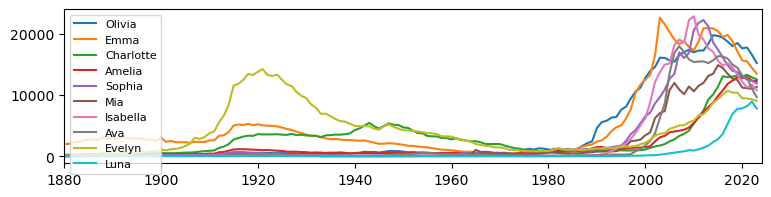

In [84]:
plt.figure(figsize=(9,2))

for name in getyear('F', 2023):
    plt.plot(allyears_byname.loc['F', name], label=name)

plt.axis(xmin=1880, xmax=2024)
plt.legend(loc='upper left', fontsize=8);

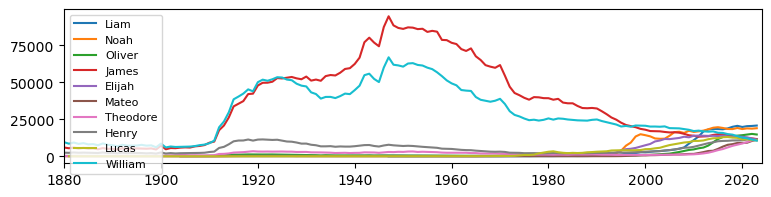

In [85]:
plt.figure(figsize=(9,2))

for name in getyear('M', 2023):
    plt.plot(allyears_byname.loc['M', name], label=name)

plt.axis(xmin=1880, xmax=2024)
plt.legend(loc='upper left', fontsize=8);

In [86]:
alltime_f = allyears_byyear.loc['F'] \
                            .groupby('name') \
                            .sum() \
                            .sort_values('number', ascending=False) \
                            .head(10)

In [87]:
alltime_f


,number
name,
Mary,4136872
Elizabeth,1674865
Patricia,1573241
Jennifer,1470608
Linda,1454476
Barbara,1436052
Margaret,1259974
Susan,1122984
Dorothy,1110746


In [88]:
allyears_byname.loc[pd.IndexSlice['F', getyear('F', 2023), :]].groupby('name').sum()


,number
name,
Amelia,255502
Ava,327483
Charlotte,427311
Emma,749903
Evelyn,621387
Isabella,395255
Luna,74374
Mia,286817
Olivia,538805


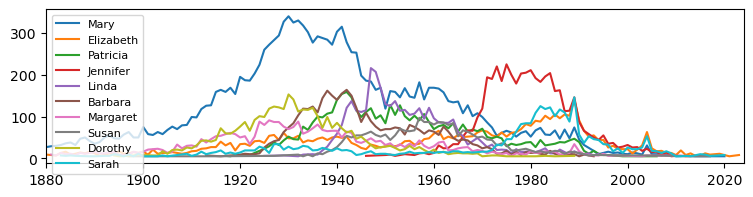

In [91]:
plt.figure(figsize=(9,2))

for name in alltime_f.index:
    plt.plot(allyears_byname.loc['M', name], label=name)

plt.axis(xmin=1880, xmax=2024)
plt.legend(loc='upper left', fontsize=8);